In [1]:
import os, shutil
import subprocess as subp
import numpy as np
import mdtraj
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
# remote options
# remote dir corresponding to dir of this notebook
remote_dir="/scratch/project_2004581/functional_sampling_tool/prod"
# remote name, either "host" or "user@host". Must be setup for passwordless connect.
remote_name="mahti"

# number of simulations per epoch
N = 16
gmx = "gmx"

# input files for grompping
mdp   = "mdrun.mdp"
topol = "topol.top"
ndx   = "index_grompp.ndx"

# sbatch template variables
email= "santeri.e.paajanen@helsinki.fi"
account="project_2004581"

In [3]:
def gromacs_command(cmd, *args, input=None, **kwargs):
    """ Call the gromacs subcommand cmd. Both args and keys of kwargs should be without the leading dash.
        output is redirected to output_<cmd>.txt.
    """
    command = [gmx, cmd]+["-"+a for a in args]
    for k in kwargs:
        command += ["-"+k, kwargs[k]]
    
    with open("output_%s.txt"%cmd, "w") as fout:
        compProc = subp.run(command, stdout=fout, stderr=subp.STDOUT, input=input)
    
    return compProc.returncode

def rsync_command(send_from, send_to, excludes=[]):
    command = ["rsync", "-ravP"]+["--exclude=%s"%e for e in excludes] + [send_from, send_to]
    compProc = subp.run(command,capture_output=True,text=True)
    print(compProc.stdout)
    print(compProc.stderr)
    return compProc.returncode

def init_rep(i):
    """ Initializes rep i
    """
    os.makedirs("epoch01/rep%02d"%i)
    
    # If not found, just load the default
    shutil.copyfile("initial/start.gro", "epoch01/rep%02d/start.gro"%i)
    print("Copied initial/start.gro to rep%02d, starting to grompp..."%i)

    # Save original working dir to come back to
    prevdir = os.getcwd()
    try:
        os.chdir("epoch01/rep%02d"%i)

        rc=gromacs_command("grompp", c="start.gro", f="../../"+mdp, n="../../"+ndx,
                           p="../../"+topol, o="mdrun.tpr", maxwarn="1")

        print("Process returned %d"%rc)

    finally:
        # Whatever happens, we go back to the original working dir
        os.chdir(prevdir)

In [4]:
rsync_excludes = ["initial", "templates", "fval.npy", "*.ipynb", "dump"]

def rsync_down():
    rc = rsync_command("%s:%s/"%(remote_name,remote_dir), "./", excludes=rsync_excludes)
    print("Process returned %d"%rc)

    
def rsync_up():
    rc = rsync_command( "./", "%s:%s/"%(remote_name,remote_dir), excludes=rsync_excludes)
    print("Process returned %d"%rc)

In [5]:
# Make a pdb file for mdtraj

# Save original working dir to come back to
prevdir = os.getcwd()
try:
    os.chdir("initial")

    rc = gromacs_command("trjconv", f="start.gro", s="start.gro", o="start.pdb", input=b"0\n")
    print("Process returned %d"%rc)
finally:
    # Whatever happens, we go back to the original working dir
    os.chdir(prevdir)

Process returned 0


In [5]:
rsync_down()

receiving incremental file list
./
epoch07/output.txt

              0   0%    0.00kB/s    0:00:00  
         24,304 100%   23.18MB/s    0:00:00 (xfr#1, to-chk=234/1300)
epoch07/rep01/
epoch07/rep01/#mdrun.edr.1#

              0   0%    0.00kB/s    0:00:00  
      1,349,256 100%    1.37MB/s    0:00:00 (xfr#2, to-chk=216/1300)
epoch07/rep01/#mdrun.log.1#

              0   0%    0.00kB/s    0:00:00  
        196,608  14%  186.23kB/s    0:00:06  
      1,355,659 100%    1.22MB/s    0:00:01 (xfr#3, to-chk=215/1300)
epoch07/rep01/#mdrun.xtc.1#

              0   0%    0.00kB/s    0:00:00  
     99,844,096  14%   95.22MB/s    0:00:06  
    216,072,192  31%  103.08MB/s    0:00:04  
    333,348,864  47%  106.04MB/s    0:00:03  
    449,609,728  64%  107.28MB/s    0:00:02  
    566,853,632  81%  111.43MB/s    0:00:01  
    684,064,768  98%  111.66MB/s    0:00:00  
    695,629,380 100%  108.84MB/s    0:00:06 (xfr#4, to-chk=214/1300)
epoch07/rep01/mdrun.cpt

              0   0%    0.00kB/s    

In [5]:
# Initial structures and first epoch
os.makedirs("epoch01", exist_ok=False)

for i in range(1,N+1):
    init_rep(i)

Copied initial/start.gro to rep01, starting to grompp...
Process returned 0
Copied initial/start.gro to rep02, starting to grompp...
Process returned 0
Copied initial/start.gro to rep03, starting to grompp...
Process returned 0
Copied initial/start.gro to rep04, starting to grompp...
Process returned 0
Copied initial/start.gro to rep05, starting to grompp...
Process returned 0
Copied initial/start.gro to rep06, starting to grompp...
Process returned 0
Copied initial/start.gro to rep07, starting to grompp...
Process returned 0
Copied initial/start.gro to rep08, starting to grompp...
Process returned 0
Copied initial/start.gro to rep09, starting to grompp...
Process returned 0
Copied initial/start.gro to rep10, starting to grompp...
Process returned 0
Copied initial/start.gro to rep11, starting to grompp...
Process returned 0
Copied initial/start.gro to rep12, starting to grompp...
Process returned 0
Copied initial/start.gro to rep13, starting to grompp...
Process returned 0
Copied initi

In [6]:
############################## User input ############################
# To save memory we only load this selection
# mdtraj selection string https://www.mdtraj.org/1.9.5/atom_selection.html
select_str = "protein and residue 638 and not (name =~ 'H.*')"

# Minimum and maximum values to sample from between. None to ignore boundary, "start" string to use the
# initial value of the starting structure
minval=0.79
maxval=1.4


def function_val(positions):
    """
      Write here your analysis function. Positions will be
        numpy array of shape (n,m,3) for n frames of m atoms.
        Note that m is the number of atoms in the selection,
        not the whole trajectory.
      The function should return a numpy array of shape (n).
    """
    m = positions.shape[-2]
    # 4 residues match, so we separate them
    m_res = m//4
    # selections for each res
    ind1 = np.array(list(range(m_res)))
    ind2 = m_res+ind1
    ind3 = m_res+ind2
    ind4 = m_res+ind3
    
    # distances between average position of res1 to average position of res3
    dist1 = np.linalg.norm(np.mean(positions[:,ind1,:], axis=-2)-np.mean(positions[:,ind3,:], axis=-2), axis=-1)
    # same for res 2 and 4
    dist2 = np.linalg.norm(np.mean(positions[:,ind2,:], axis=-2)-np.mean(positions[:,ind4,:], axis=-2), axis=-1)
    
    return np.minimum(dist1, dist2)



############################## User input ############################

In [7]:
load_fval = False # set to True to recalculate analysis even if fval.npy is present
epoch_dir = "" # set if current dir is not the dir with the epoch-directories (and initial-dir)

def load_data(struct, sel, epoch):
    fval = []
    for i in range(1,N+1):
        d = epoch_dir+"epoch%02d/rep%02d/"%(epoch, i)
        if(not load_fval):
            try:
                fval.append(np.load(d+"fval.npy"))
                print("Loaded fval from %sfval.npy"%d)
                continue
            except FileNotFoundError:
                print("Could not open %s"%(d+"fval.npy"))
                
        print("Loading trajectory %s"%(d+"mdrun.xtc"))
        traj = mdtraj.load(d+"mdrun.xtc", top=struct,atom_indices=sel)
        print("Calculating fval")
        fval.append(function_val(traj.xyz))
        print("Saving fval")
        np.save(d+"fval.npy", fval[-1])
    
    reps = [np.full(f.shape,i+1) for i,f in enumerate(fval)]
    frms = [np.arange(len(f)) for f in fval]
    
    return np.concatenate(reps), np.concatenate(fval), np.concatenate(frms)

In [8]:
print("Loading structure and making selection")
struct = mdtraj.load(epoch_dir+"initial/start.pdb")
sel = struct.topology.select(select_str)

startval = function_val(struct.xyz[:,sel,:])

# Min and maxvals
if(minval=="start"):
    minval=startval
elif(minval is None):
    minval=-np.inf

if(maxval=="start"):
    maxval=startval
elif(minval is None):
    maxval=np.inf


print("Selected %d atoms"%len(sel))

Loading structure and making selection
Selected 28 atoms


In [13]:
epochs = 7
fval = []
reps = []
frms = []
for i in range(1,epochs+1):
    r,f,fr = load_data(struct, sel, i)
    reps.append(r)
    fval.append(f)
    frms.append(fr)

    
epcs = [np.full(f.shape,i+1) for i,f in enumerate(fval)]

reps = np.concatenate(reps)
fval = np.concatenate(fval)
epcs = np.concatenate(epcs)
frms = np.concatenate(frms)

Loaded fval from epoch01/rep01/fval.npy
Loaded fval from epoch01/rep02/fval.npy
Loaded fval from epoch01/rep03/fval.npy
Loaded fval from epoch01/rep04/fval.npy
Loaded fval from epoch01/rep05/fval.npy
Loaded fval from epoch01/rep06/fval.npy
Loaded fval from epoch01/rep07/fval.npy
Loaded fval from epoch01/rep08/fval.npy
Loaded fval from epoch01/rep09/fval.npy
Loaded fval from epoch01/rep10/fval.npy
Loaded fval from epoch01/rep11/fval.npy
Loaded fval from epoch01/rep12/fval.npy
Loaded fval from epoch01/rep13/fval.npy
Loaded fval from epoch01/rep14/fval.npy
Loaded fval from epoch01/rep15/fval.npy
Loaded fval from epoch01/rep16/fval.npy
Loaded fval from epoch02/rep01/fval.npy
Loaded fval from epoch02/rep02/fval.npy
Loaded fval from epoch02/rep03/fval.npy
Loaded fval from epoch02/rep04/fval.npy
Loaded fval from epoch02/rep05/fval.npy
Loaded fval from epoch02/rep06/fval.npy
Loaded fval from epoch02/rep07/fval.npy
Loaded fval from epoch02/rep08/fval.npy
Loaded fval from epoch02/rep09/fval.npy


67205
1.4 0.79 60795 607 0.009283149242401123


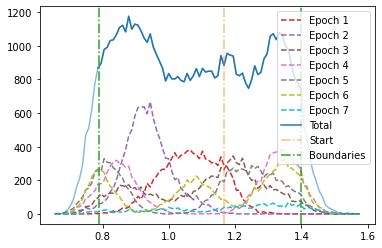

In [14]:
print(len(fval))
_largest_val = np.max(fval)
_lowest_val  = np.min(fval)
_binmax = min(_largest_val, maxval)
_binmin = max(_lowest_val,  minval)
_maxbins = np.sum((fval>minval)*(fval<maxval))//100
_binsize = (_largest_val-_lowest_val)/min(_maxbins,100)
print(_binmax,_binmin, np.sum((fval>minval)*(fval<maxval)),_maxbins,_binsize)
bin_edges = np.arange(_lowest_val,_largest_val+_binsize , _binsize)
hist, bin_edges = np.histogram(fval, bins=bin_edges)
bin_centers = (bin_edges[:-1]+bin_edges[1:])/2
# higher edge larger than minval AND lower edge lower than maxval
mask = (bin_edges[1:]>minval)*(bin_edges[:-1]<maxval)

for i in range(1,epochs+1):
    _ep_hist, _ = np.histogram(fval[epcs==i], bins=bin_edges)
    plt.plot(bin_centers, _ep_hist, "--", color="C%d"%(i+2), label="Epoch %d"%i)


plt.plot(bin_centers, hist, color="C0", alpha=0.5)
plt.plot(bin_centers[mask], hist[mask], color="C0", label="Total")
plt.axvline(startval, linestyle="-.", color="C1", label="Start", alpha=0.5)
plt.axvline(minval, linestyle="-.", color="C2", label="Boundaries")
plt.axvline(maxval, linestyle="-.", color="C2")
plt.legend()
plt.show()


In [15]:
from math import floor, ceil

def rolling_mean(data, window=10, center = True, fill=np.nan):
    if(center):
        start_offset = floor(window/2)
        end_offset   = -ceil(window/2)+1
        if(end_offset==0): end_offset=None
    else:
        start_offset = window-1
        end_offset   = None

    window-=1
    if(window==0): window=None

    cumsum = np.nancumsum(data, axis=0, dtype=float)
    mean   = np.full_like(cumsum, fill)
    mean[start_offset:end_offset] = (cumsum[window:]-cumsum[:-window])/window

    return mean


[26 49] {'prominences': array([211.        ,  69.33333333]), 'left_bases': array([10, 40]), 'right_bases': array([58, 58]), 'widths': array([33.22964252,  5.71314416]), 'width_heights': array([-912.16666667, -853.44444444]), 'left_ips': array([20.14449541, 45.70238095]), 'right_ips': array([53.37413793, 51.41552511])}
[10 40 58] {'prominences': array([317.11111111,  69.33333333, 211.        ]), 'left_bases': array([ 0, 26, 26]), 'right_bases': array([66, 49, 66]), 'widths': array([16.03667505,  8.70238095,  8.93066976]), 'width_heights': array([952.22222222, 853.44444444, 912.16666667]), 'left_ips': array([ 2.62474227, 37.        , 53.37413793]), 'right_ips': array([18.66141732, 45.70238095, 62.30480769])}
[40, 63, 80, 14] [2.57272727 3.84545455 3.95454545 1.62727273]
[80, 63, 40, 14] [3.95454545 3.84545455 2.57272727 1.62727273]
16 (array([14, 40, 63, 80]), array([2, 4, 5, 5]))


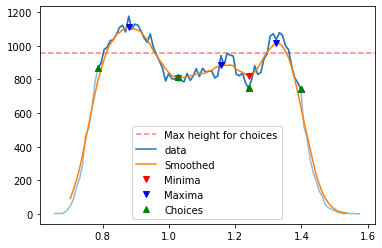

In [16]:
_smoothed = rolling_mean(-hist)
_nanmask = np.isfinite(_smoothed)*mask
_peaks,_que = scipy.signal.find_peaks(_smoothed[_nanmask], width=5, distance=10)
_peaks2,_que2 = scipy.signal.find_peaks(-_smoothed[_nanmask], width=5, distance=10)
print(_peaks, _que)
print(_peaks2, _que2)


_maxh = np.max(hist[mask])
_minh = np.min(hist[mask])
# If not ends have sampled been, make sure min height set to zero is
if(_largest_val<maxval or _lowest_val>minval):
    _minh=0

_crith = (_maxh-_minh)/2+_minh

choices = []
# convert from masked indices to unmasked
_indexes = np.arange(len(hist))[_nanmask]
for p in _peaks:
    if(hist[_nanmask][p]<_crith):
        choices.append(_indexes[p])

_zero_mask = mask*(hist!=0)
_indexes = np.arange(len(hist))[_zero_mask]

# TODO: refactor below
#Handle not peaks-edge case
if(_peaks.size==0):
    if(hist[mask][-1]<_crith):
        choices.append(_indexes[-1])
    if(hist[mask][0]<_crith):
        choices.append(_indexes[0])
else:
    # Check if first/last extrema is a maxima -> also include the far end(s)
    if(_peaks2.size>0 and _peaks[-1]<_peaks2[-1] and hist[mask][-1]<_crith):
        choices.append(_indexes[-1])
    if(_peaks2.size>0 and _peaks[0]>_peaks2[0] and hist[mask][0]<_crith):
        choices.append(_indexes[0])

_weights = [(_crith-hist[c]) for c in choices]
_weights /= np.sum(_weights)
print(choices,(_weights*(N-len(choices))))
_srt_ind = np.argsort(-_weights)
print([choices[i] for i in _srt_ind],(_weights[_srt_ind]*(N-len(choices))))

# Each point has been added once
_len_choice = len(choices)
# Add more depending on weight. Multiplication is floored, so between 0 and _len_choice-1 too few are added
for i in _srt_ind:
    for j in range(floor(_weights[i]*(N-_len_choice))):
        choices.append(choices[i])

# Fill the rest in sorted order
for i in range(N-len(choices)):
    choices.append(choices[_srt_ind[i]])


print(len(choices), np.unique(choices, return_counts=True))

plt.axhline(_crith, linestyle="--", c="r", alpha=0.5, label="Max height for choices")
plt.plot(bin_centers, hist, color="C0", alpha=0.5)
plt.plot(bin_centers[mask], hist[mask], color="C0", label="data")
plt.plot(bin_centers, -_smoothed, color="C1", label="Smoothed")
plt.plot(bin_centers[_nanmask][_peaks], -_smoothed[_nanmask][_peaks], "rv", label="Minima")
plt.plot(bin_centers[_nanmask][_peaks2], -_smoothed[_nanmask][_peaks2], "bv", label="Maxima")
plt.plot(bin_centers[choices], hist[choices], "g^", label="Choices")
plt.legend()
plt.show()


chosen_bins=choices

In [17]:
def check_pathways():
    """ Checks how well each bin is connected to its neighbours.
        A one way connection is established when a simulation moves from one bin to another.
        Returns a num_bins*num_bins matrix of the number of jumps from each bin to another.
    """
    global bin_edges, fval, frms
    
    # get histogram bin indexes for each frame
    data_bins = np.digitize(fval, bin_edges)
    # Shift so first bin is 0
    data_bins-=1
    # Mask where frame is not incremental (ie. rep or epoch changes)
    mask = (frms[:-1]==(frms[1:]-1))
    print(len(mask),np.sum(mask))
    
    # matrix of jumps
    jumps = np.zeros((len(bin_edges-1),len(bin_edges-1)),dtype=int)
    # Iterate over 2dimension of bins
    for i,j in np.ndindex(jumps.shape):
        # sum of jumps from i to j, masked
        jumps[i,j] = np.sum((data_bins[:-1]==i)*(data_bins[1:]==j)*mask)
    
    return jumps

jumps = check_pathways()
print(bin_edges[1]-bin_edges[0])
for i in range(50):
    print(np.sum(np.diagonal(jumps, offset=i)+(i!=0)*np.diagonal(jumps, offset=-i)),i)


67204 67093
0.009283149242401145
4710 0
9216 1
9149 2
8319 3
7128 4
6335 5
5309 6
4252 7
3374 8
2589 9
1958 10
1417 11
1039 12
762 13
510 14
345 15
244 16
166 17
103 18
68 19
37 20
19 21
17 22
12 23
6 24
5 25
1 26
0 27
1 28
1 29
0 30
0 31
0 32
1 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49


In [18]:
def choose_frames(chosen_bins):
    """ Input parameters:
            - chosen_bins : Length N list of the indices of the bins that have been chosen.
                            Duplicates (starting from the same bin) are simply many times in the list.
        Output:
            - v : Length N array of the fvals for each new rep
            - e : Length N array of the epochs each new rep comes from
            - r : Length N array of the rep within the epoch each new rep comes from
            - f : Length N array of the frame within the rep each new rep comes from
        
        Other "inputs":
            (At least for now) as global variables:
            - bin_edges : Edges of the bins, so bin_edges[i] is the left, and bin_edges[i+1]
                          the right edge of the i'th bin. As per numpy.histogram, each bin is half open
                          [left_edge, right_edge), except for the last one [left_edge, right_edge].
            - fval      : An array containing all the fvals from all the simulations so far.
            - epcs      : An array of same shape as fval, with each element being the corresponding
                          epoch each value comes from.
            - reps      : Same as epcs, but with the corresponding rep.
            - frms      : Same as epcs and reps, but with the information of the frame.
    """
    
    global bin_edges, fval, epcs, reps, frms
    
    _rng = np.random.default_rng()
    # lists for value, rpoch, rep and frame
    v,e,r,f=[],[],[],[]
    for bi in chosen_bins:
        vals_in_bin = (fval >= bin_edges[bi])*(fval < bin_edges[bi+1])
        ndx = _rng.choice(np.sum(vals_in_bin))
        
        v.append(fval[vals_in_bin][ndx])
        e.append(epcs[vals_in_bin][ndx])
        r.append(reps[vals_in_bin][ndx])
        f.append(frms[vals_in_bin][ndx])
    
    return np.array(v), np.array(e), np.array(r), np.array(f)


def next_rep(i,newepoch,oldepoch,rep,frm, val):
    """ Initializes rep i of newepoch, taking the frame frm from rep of oldepoch
    """
    global struct
    os.makedirs("epoch%02d/rep%02d"%(newepoch, i))
    
    print("Reading frame %d of epoch %d, rep %d"%(frm, oldepoch, rep))
    init_struct = mdtraj.load_frame("epoch%02d/rep%02d/mdrun.xtc"%(oldepoch, rep), frm, top=struct)
    
    init_struct.save_gro("epoch%02d/rep%02d/start.gro"%(newepoch, i))
    print("Wrote structure to epoch%02d/rep%02d/start.gro, starting to grompp..."%(newepoch, i))
    
    # Make a note of the origin
    with open("epoch%02d/rep%02d/origin.txt"%(newepoch, i), "w") as f:
        f.write("# Origin of this trajectory:\n")
        f.write("# epoch rep frame val\n")
        f.write("%d %d %d %f\n"%(oldepoch,rep,frm, val))

    # Save original working dir to come back to
    prevdir = os.getcwd()
    try:
        os.chdir("epoch%02d/rep%02d"%(newepoch, i))
        
        # The pdb structure seems to change the atom names, so maxwarn is 2
        rc=gromacs_command("grompp", c="start.gro", f="../../"+mdp, n="../../"+ndx,
                           p="../../"+topol, o="mdrun.tpr", maxwarn="2")

        print("Process returned %d"%rc)

    finally:
        # Whatever happens, we go back to the original working dir
        os.chdir(prevdir)
        
def start_epoch(nextepoch):
    global email, account
    v, e, r, f = choose_frames(chosen_bins)
    print(v, e, r, f)
    
    os.makedirs("epoch%02d"%(nextepoch))
        
    # copy sbatch template
    with open("templates/sbatch_launch.sh") as fin:
        with open("epoch%02d/sbatch_launch.sh"%nextepoch, "w") as fout:
            fout.write(fin.read().format(i=nextepoch, account=account, email=email))

    for i, (val, epoch, rep, frm) in enumerate(zip(v,e,r,f)):
        next_rep(i+1, nextepoch, epoch, rep, frm, val)

In [15]:
nextepoch = epochs+1
print(nextepoch)
start_epoch(nextepoch)

7
[1.0304399  1.2445394  1.4000964  0.7912383  1.4015431  1.394313
 1.4023821  1.400324   1.2483144  1.2425663  1.2452117  1.0311909
 1.0240232  0.78940773 1.3997314  1.2441454 ] [1 3 3 4 4 4 6 6 5 4 5 1 1 2 3 3] [ 6 11  1 10  6  7 16 16 15  3  8 12 13  7  1  5] [189 594 224 600 380 336 100 537 702 613 313 582 284 230 449 472]
Reading frame 189 of epoch 1, rep 6
Wrote structure to epoch07/rep01/start.gro, starting to grompp...
Process returned 0
Reading frame 594 of epoch 3, rep 11
Wrote structure to epoch07/rep02/start.gro, starting to grompp...
Process returned 0
Reading frame 224 of epoch 3, rep 1
Wrote structure to epoch07/rep03/start.gro, starting to grompp...
Process returned 0
Reading frame 600 of epoch 4, rep 10
Wrote structure to epoch07/rep04/start.gro, starting to grompp...
Process returned 0
Reading frame 380 of epoch 4, rep 6
Wrote structure to epoch07/rep05/start.gro, starting to grompp...
Process returned 0
Reading frame 336 of epoch 4, rep 7
Wrote structure to epoch07/r

In [16]:
rsync_up()

sending incremental file list
./
epoch06/rep01/
epoch06/rep02/
epoch06/rep03/
epoch06/rep04/
epoch06/rep05/
epoch06/rep06/
epoch06/rep07/
epoch06/rep08/
epoch06/rep09/
epoch06/rep10/
epoch06/rep11/
epoch06/rep12/
epoch06/rep13/
epoch06/rep14/
epoch06/rep15/
epoch06/rep16/
epoch07/
epoch07/sbatch_launch.sh

            512 100%    0.00kB/s    0:00:00  
            512 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=103/1169)
epoch07/rep01/
epoch07/rep01/mdout.mdp

         10,994 100%   10.48MB/s    0:00:00  
         10,994 100%   10.48MB/s    0:00:00 (xfr#2, to-chk=86/1169)
epoch07/rep01/mdrun.tpr

         32,768   0%   31.25MB/s    0:00:00  
     13,316,856 100%   83.55MB/s    0:00:00 (xfr#3, to-chk=85/1169)
epoch07/rep01/origin.txt

             68 100%    0.44kB/s    0:00:00  
             68 100%    0.44kB/s    0:00:00 (xfr#4, to-chk=84/1169)
epoch07/rep01/output_grompp.txt

          5,978 100%   38.41kB/s    0:00:00  
          5,978 100%   38.41kB/s    0:00:00 (xfr#5, to-chk=83/116

In [19]:
def extract_frames(ndxs, outd="dump/extracted/", outf="extracted.xtc"):
    """ Extract the frames of given indexes into a single trajectory outd/outf.
        ndxs should be an array of unique indexes in an increasing order.
    """
    global epcs, reps, frms, epoch_dir, struct
    pos = []
    box = []
    for e in np.unique(epcs[ndxs]):
        for r in np.unique(reps[ndxs][epcs[ndxs]==e]):
            d = epoch_dir+"epoch%02d/rep%02d/"%(e, r)
            frs =  frms[ndxs][(epcs[ndxs]==e)*(reps[ndxs]==r)]
            print(f"Reading {frs.size} frames from {d}mdrun.xtc")
            if(not np.all(frs[1:]>frs[:-1])):
                print("frames not in order, panic")
                continue
            with mdtraj.open(d+"mdrun.xtc") as f_trj:
                for f in frs:
                    f_trj.seek(f)
                    xyz,t,step,bx = f_trj.read(1)
                    pos.append(xyz)
                    box.append(bx)
                    
            #trajs.append(mdtraj.load(d+"mdrun.xtc", top=struct)[frs])
    
    print("Joining trajectories")
    pos = np.concatenate(pos)
    box = np.concatenate(box)
    print(f"Saving to {outd+outf}")
    with mdtraj.open(outd+outf, "w")as fout:
        fout.write(pos,box=box)
        
def frames_in_closest_bin(v):
    """ Return the indexes of frames in the bin closest to the specified value.
        For all values within startval and endval this will be the bin in which the value would get
        sorted to, for values outside the range the closest edge bin.
    """
    global bin_centers, fval, bin_edges
    bi = np.argmin(np.abs(v-bin_centers))
    vals_in_bin = (fval >= bin_edges[bi])*(fval < bin_edges[bi+1])
    return vals_in_bin

In [20]:
extract_frames(frames_in_closest_bin(startval), outf="startval.xtc")
extract_frames(frames_in_closest_bin(minval), outf="minval.xtc")
extract_frames(frames_in_closest_bin(maxval), outf="maxval.xtc")
extract_frames(frames_in_closest_bin(1.0), outf="frames_at_1.0.xtc")

Reading 50 frames from epoch01/rep01/mdrun.xtc
Reading 3 frames from epoch01/rep02/mdrun.xtc
Reading 49 frames from epoch01/rep03/mdrun.xtc
Reading 7 frames from epoch01/rep04/mdrun.xtc
Reading 7 frames from epoch01/rep05/mdrun.xtc
Reading 3 frames from epoch01/rep06/mdrun.xtc
Reading 24 frames from epoch01/rep07/mdrun.xtc
Reading 2 frames from epoch01/rep08/mdrun.xtc
Reading 5 frames from epoch01/rep09/mdrun.xtc
Reading 4 frames from epoch01/rep10/mdrun.xtc
Reading 48 frames from epoch01/rep11/mdrun.xtc
Reading 4 frames from epoch01/rep12/mdrun.xtc
Reading 1 frames from epoch01/rep13/mdrun.xtc
Reading 61 frames from epoch01/rep14/mdrun.xtc
Reading 15 frames from epoch01/rep15/mdrun.xtc
Reading 5 frames from epoch01/rep16/mdrun.xtc
Reading 7 frames from epoch02/rep10/mdrun.xtc
Reading 2 frames from epoch03/rep01/mdrun.xtc
Reading 52 frames from epoch03/rep02/mdrun.xtc
Reading 1 frames from epoch03/rep04/mdrun.xtc
Reading 23 frames from epoch03/rep05/mdrun.xtc
Reading 26 frames from epo

Joining trajectories
Saving to dump/extracted/frames_at_1.0.xtc
